
# CMU Movie Summary Corpus — Phase 1: Ingest, Clean, and Plot

**Dataset**: "Movie Summaries" (a.k.a. IMDb 5000 Movie Dataset)
URL: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

Files we will use:
- `movie.metadata.tsv`  (tab-separated; includes movie name, date, **box office revenue**, runtime, languages, countries, genres)
- `plot_summaries.txt`  (optional; text plots, not needed for Phase 1)

**Today**
1) Download & extract the tar.gz
2) Read `movie.metadata.tsv` into pandas
3) Clean/transform: parse lists (genres/languages/countries), extract release year, cast revenue to numeric
4) Create **year-relative revenue tiers**: hit (top 25%), average (mid 50%), flop (bottom 25%)
5) Plots: revenue distribution (log10), top genres by count, hits by year


In [1]:

import os, tarfile, json, ast
from pathlib import Path
from urllib.request import urlretrieve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

DATA_URL = "https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
DATA_DIR = Path("/content/data/cmu_movie_summaries")
TAR_PATH  = DATA_DIR / "MovieSummaries.tar.gz"
EXTRACT_DIR = DATA_DIR / "MovieSummaries"

DATA_DIR.mkdir(parents=True, exist_ok=True)
print("Data dir:", DATA_DIR.resolve())


Data dir: /content/data/cmu_movie_summaries



## **Download & Extract**
If you're offline, upload `MovieSummaries.tar.gz` to `/content/data/cmu_movie_summaries/` and rerun extraction.


In [2]:

if not TAR_PATH.exists():
    print("Downloading MovieSummaries.tar.gz ...")
    urlretrieve(DATA_URL, TAR_PATH)
    print("Download complete.")
else:
    print("Archive already present; skipping download.")


Download complete.


In [6]:
TAR_PATH="/content/data/cmu_movie_summaries/MovieSummaries.tar.gz"

In [8]:

EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with tarfile.open(TAR_PATH, "r:gz") as tf:
    tf.extractall(EXTRACT_DIR)
print("Extracted to:", EXTRACT_DIR)




/tmp/ipython-input-2517264652.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(EXTRACT_DIR)


Extracted to: /content/data/cmu_movie_summaries/MovieSummaries



## **Inspect files and read `movie.metadata.tsv`**
Column order (from dataset README/codebooks commonly used):
- 0: wikipedia_movie_id
- 1: freebase_id
- 2: movie_name
- 3: movie_release_date
- 4: movie_box_office_revenue
- 5: movie_runtime
- 6: movie_languages (JSON-like list of ["Language", weight])
- 7: movie_countries (JSON-like list)
- 8: movie_genres (JSON-like dict of {"FreebaseID": "GenreName"})





In [9]:

meta_path = next(EXTRACT_DIR.rglob("movie.metadata.tsv"))
plots_path = next(EXTRACT_DIR.rglob("plot_summaries.txt"))

print("metadata path:", meta_path)
print("plots path   :", plots_path)

colnames = [
    "wikipedia_movie_id","freebase_id","movie_name","movie_release_date",
    "movie_box_office_revenue","movie_runtime","movie_languages",
    "movie_countries","movie_genres"
]
meta = pd.read_csv(meta_path, sep="\t", header=None, names=colnames, dtype=str)

meta.head()


metadata path: /content/data/cmu_movie_summaries/MovieSummaries/MovieSummaries/movie.metadata.tsv
plots path   : /content/data/cmu_movie_summaries/MovieSummaries/MovieSummaries/plot_summaries.txt


,wikipedia_movie_id,freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"



## **Clean & Transform**
- Parse `movie_box_office_revenue` → numeric (USD; may contain missing or zeros)
- Parse `movie_runtime` → numeric (minutes)
- Extract `release_year` from `movie_release_date`
- Parse JSON-like strings for languages, countries, genres
- Build `genres_list` (flat list)


In [10]:

def to_float(x):
    try:
        if x is None or x == "" or pd.isna(x): return np.nan
        return float(x)
    except Exception:
        return np.nan

def parse_jsonish(s):
    """Safely parse JSON-ish strings (dataset uses Python-literal style)."""
    if s is None or pd.isna(s) or s == "":
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def extract_year(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str) or not date_str.strip():
        return np.nan
    # date formats vary; try last 4 digits or first 4 digits
    import re
    m = re.search(r"(\d{4})", date_str)
    return float(m.group(1)) if m else np.nan

meta["movie_box_office_revenue"] = meta["movie_box_office_revenue"].apply(to_float)
meta["movie_runtime"] = meta["movie_runtime"].apply(to_float)
meta["release_year"] = meta["movie_release_date"].apply(extract_year)

meta["languages_parsed"] = meta["movie_languages"].apply(parse_jsonish)
meta["countries_parsed"] = meta["movie_countries"].apply(parse_jsonish)
meta["genres_parsed"]    = meta["movie_genres"].apply(parse_jsonish)

# genres_parsed is a dict of {freebase_id: "GenreName"} → flatten to list of names
def genres_to_list(gdict):
    if isinstance(gdict, dict):
        return sorted(list(set(gdict.values())))
    return []

meta["genres_list"] = meta["genres_parsed"].apply(genres_to_list)

# quick peek
meta[["movie_name","release_year","movie_box_office_revenue","movie_runtime","genres_list"]].head()


,movie_name,release_year,movie_box_office_revenue,movie_runtime,genres_list
0,Ghosts of Mars,2001.0,14010832.0,98.0,"[Action, Adventure, Horror, Science Fiction, S..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,"[Biographical film, Crime Drama, Drama, Mystery]"
2,Brun bitter,1988.0,NaN,83.0,"[Crime Fiction, Drama]"
3,White Of The Eye,1987.0,NaN,110.0,"[Erotic thriller, Psychological thriller, Thri..."
4,A Woman in Flames,1983.0,NaN,106.0,[Drama]


In [11]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  object 
 1   freebase_id               81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
 9   release_year              74839 non-null  float64
 10  languages_parsed          81741 non-null  object 
 11  countries_parsed          81741 non-null  object 
 12  genres_parsed             81741 non-null  object 
 13  genres_list               81741 non-null  object 
dtypes: flo


##  **Label year-relative revenue tiers (Hit / Average / Flop)**
We use within-year percentiles to avoid inflation effects:
- Hit:    revenue >= 75th percentile of that year
- Average: between 25th and 75th
- Flop:   < 25th
Rows with missing/zero revenue get "unknown".


In [12]:

import numpy as np
import pandas as pd

df = meta.copy()

# treat nonpositive or missing as NaN for tiering
df["valid_revenue"] = df["movie_box_office_revenue"].where(
    (meta["movie_box_office_revenue"].notna()) & (meta["movie_box_office_revenue"] > 0),
    np.nan
)

def label_within_year(group: pd.DataFrame) -> pd.Series:
    vals = group["valid_revenue"].dropna()
    # if too few films with revenue, mark unknown
    if len(vals) < 20:
        return pd.Series(["unknown"] * len(group), index=group.index)
    q25, q75 = np.nanpercentile(vals, [25, 75])
    def lab(v):
        if pd.isna(v): return "unknown"
        if v < q25:    return "flop"
        if v >= q75:   return "hit"
        return "average"
    return group["valid_revenue"].apply(lab)

df["tier"] = (
    df.groupby(df["release_year"].astype("Int64"), group_keys=False)
      .apply(label_within_year)
)

df["tier"].value_counts(dropna=False)


,count
tier,
unknown,66866
NaN,6902
average,3965
hit,2015
flop,1993



 ##  **Plots Distribution**, Top Genres, Hits per Year


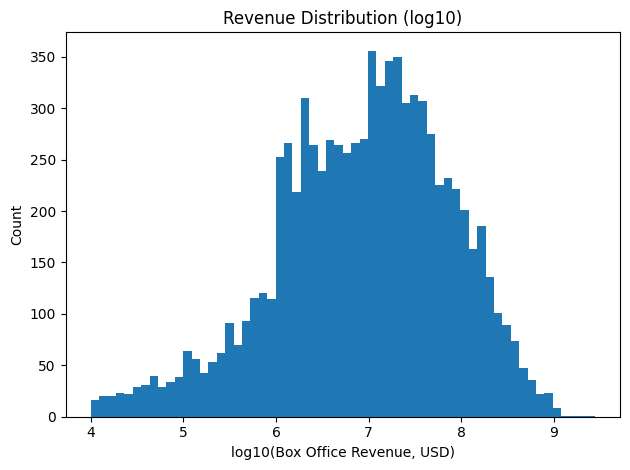

In [13]:
#  Revenue distribution (log10, valid only)
import matplotlib.pyplot as plt
rev = df["valid_revenue"].dropna()
plt.figure()
np.log10(rev[rev>0]).plot(kind="hist", bins=60)
plt.xlabel("log10(Box Office Revenue, USD)")
plt.ylabel("Count")
plt.title("Revenue Distribution (log10)")
plt.tight_layout()
plt.show()


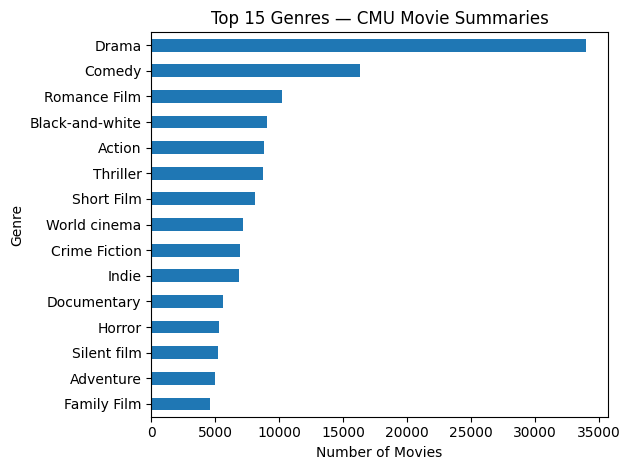

In [14]:
#  Top 15 genres by movie count
genres_exploded = df.explode("genres_list")
top_genres = (
    genres_exploded["genres_list"]
    .dropna()
    .value_counts()
    .head(15)
    .sort_values(ascending=True)
)
plt.figure()
top_genres.plot(kind="barh")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Top 15 Genres — CMU Movie Summaries")
plt.tight_layout()
plt.show()


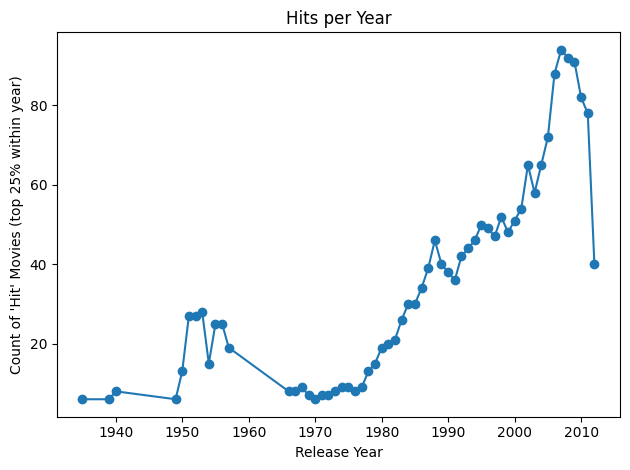

In [15]:
#  Number of 'hits' per year
hits_per_year = (
    df.loc[df["tier"]=="hit"]
      .groupby(df["release_year"].astype("Int64"))
      .size()
      .rename("hits")
      .sort_index()
)
plt.figure()
hits_per_year.plot(kind="line", marker="o")
plt.xlabel("Release Year")
plt.ylabel("Count of 'Hit' Movies (top 25% within year)")
plt.title("Hits per Year")
plt.tight_layout()
plt.show()
